# ЗАДАЧА №1(Задача Каспи Банк)
#### Вы должны построить алгоритм для автоматической оценки автомобилей. У Вас есть витрина с эталонной оценкой "Train". На основе ее анализа Вам нужно оценить автомобили в витрине "Test".

#### Описание полей
- YEAR – возраст авто (год оценки – год выпуска авто)
- VIN_TOTAL – полный ВИН-код и далее каждый из 17 символов в отдельности
- ENGINE_VOLUME – объем двигателя
- FUEL_TYPE – тип топлива
- BODY_TYPE – тип кузова
- TYPE_OF_DIVE – тип привода
- INTERIOR_TYPE – тип салона
- TRANSM_TYPE – тип КПП
- AUTO_CONDITION – тех. состояние авто
- AVG_COST – средн. рыночная стоимость


Для успешного выполнения задания нужно, чтобы более 78% проставленных оценок  в витрине TEST были  в диапазоне +/- 10% от фактических значений

Ответ должен быть в виде файла в формате excel
В файле должен быть только один лист и содержать 2 столбца :
- ID
- ESTIM_COST
Не должно быть скрытых страниц и столбцов
Записи должны начинаться с ячейки А1

VIN-код (Vehicle Identification Number) — это идентификационный номер транспортного средства, состоящий из 17 символов. В коде представлена информация о производителе, характеристиках транспортного средства и годе выпуска.
Первый символ означает географическую зону. Каждой из зон присвоено несколько символов:
- от A до H — Африка;
- от J до R — Азия;
- от S до Z — Европа;
- от 1 до 5 — Северная Америка;
- от 6 до 7 — Океания;
- от 8 до 9 — Южная Америка.

Второй символ означает страну. Конкретная страна определяется по сочетанию первой и второй цифр кода. Например: JA-JT Япония

Третий символ может означать тип транспортного средства или производственный отдел. Например: T - Toyota

Пятнадцатый, шестнадцатый и семнадцатый символы - Серийный номер

## Вначале подключим библиотеки

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Загружаем данные

In [39]:
data = pd.read_csv('train.csv', delimiter=";", encoding="windows-1251")
test = pd.read_csv('test.csv', delimiter=";", encoding="windows-1251")

## Анализируем данные

Узнаем размеры таблицы:

In [40]:
data.shape

(6000, 17)

In [41]:
test.shape

(3249, 16)

Итак, таблица с данными для обучения содержит 6000 строк (объектов) и 17 столбцов (признаков), включая выходной (целевой) признак.

Таблица с данным для тестирования модели содержит 3249 строк (объектов) и 26 столбцов (признаков).

Функция scatter_matrix из модуля pandas.tools.plotting позволяет построить для каждой количественной переменной гистограмму, а для каждой пары таких переменных – диаграмму рассеяния:

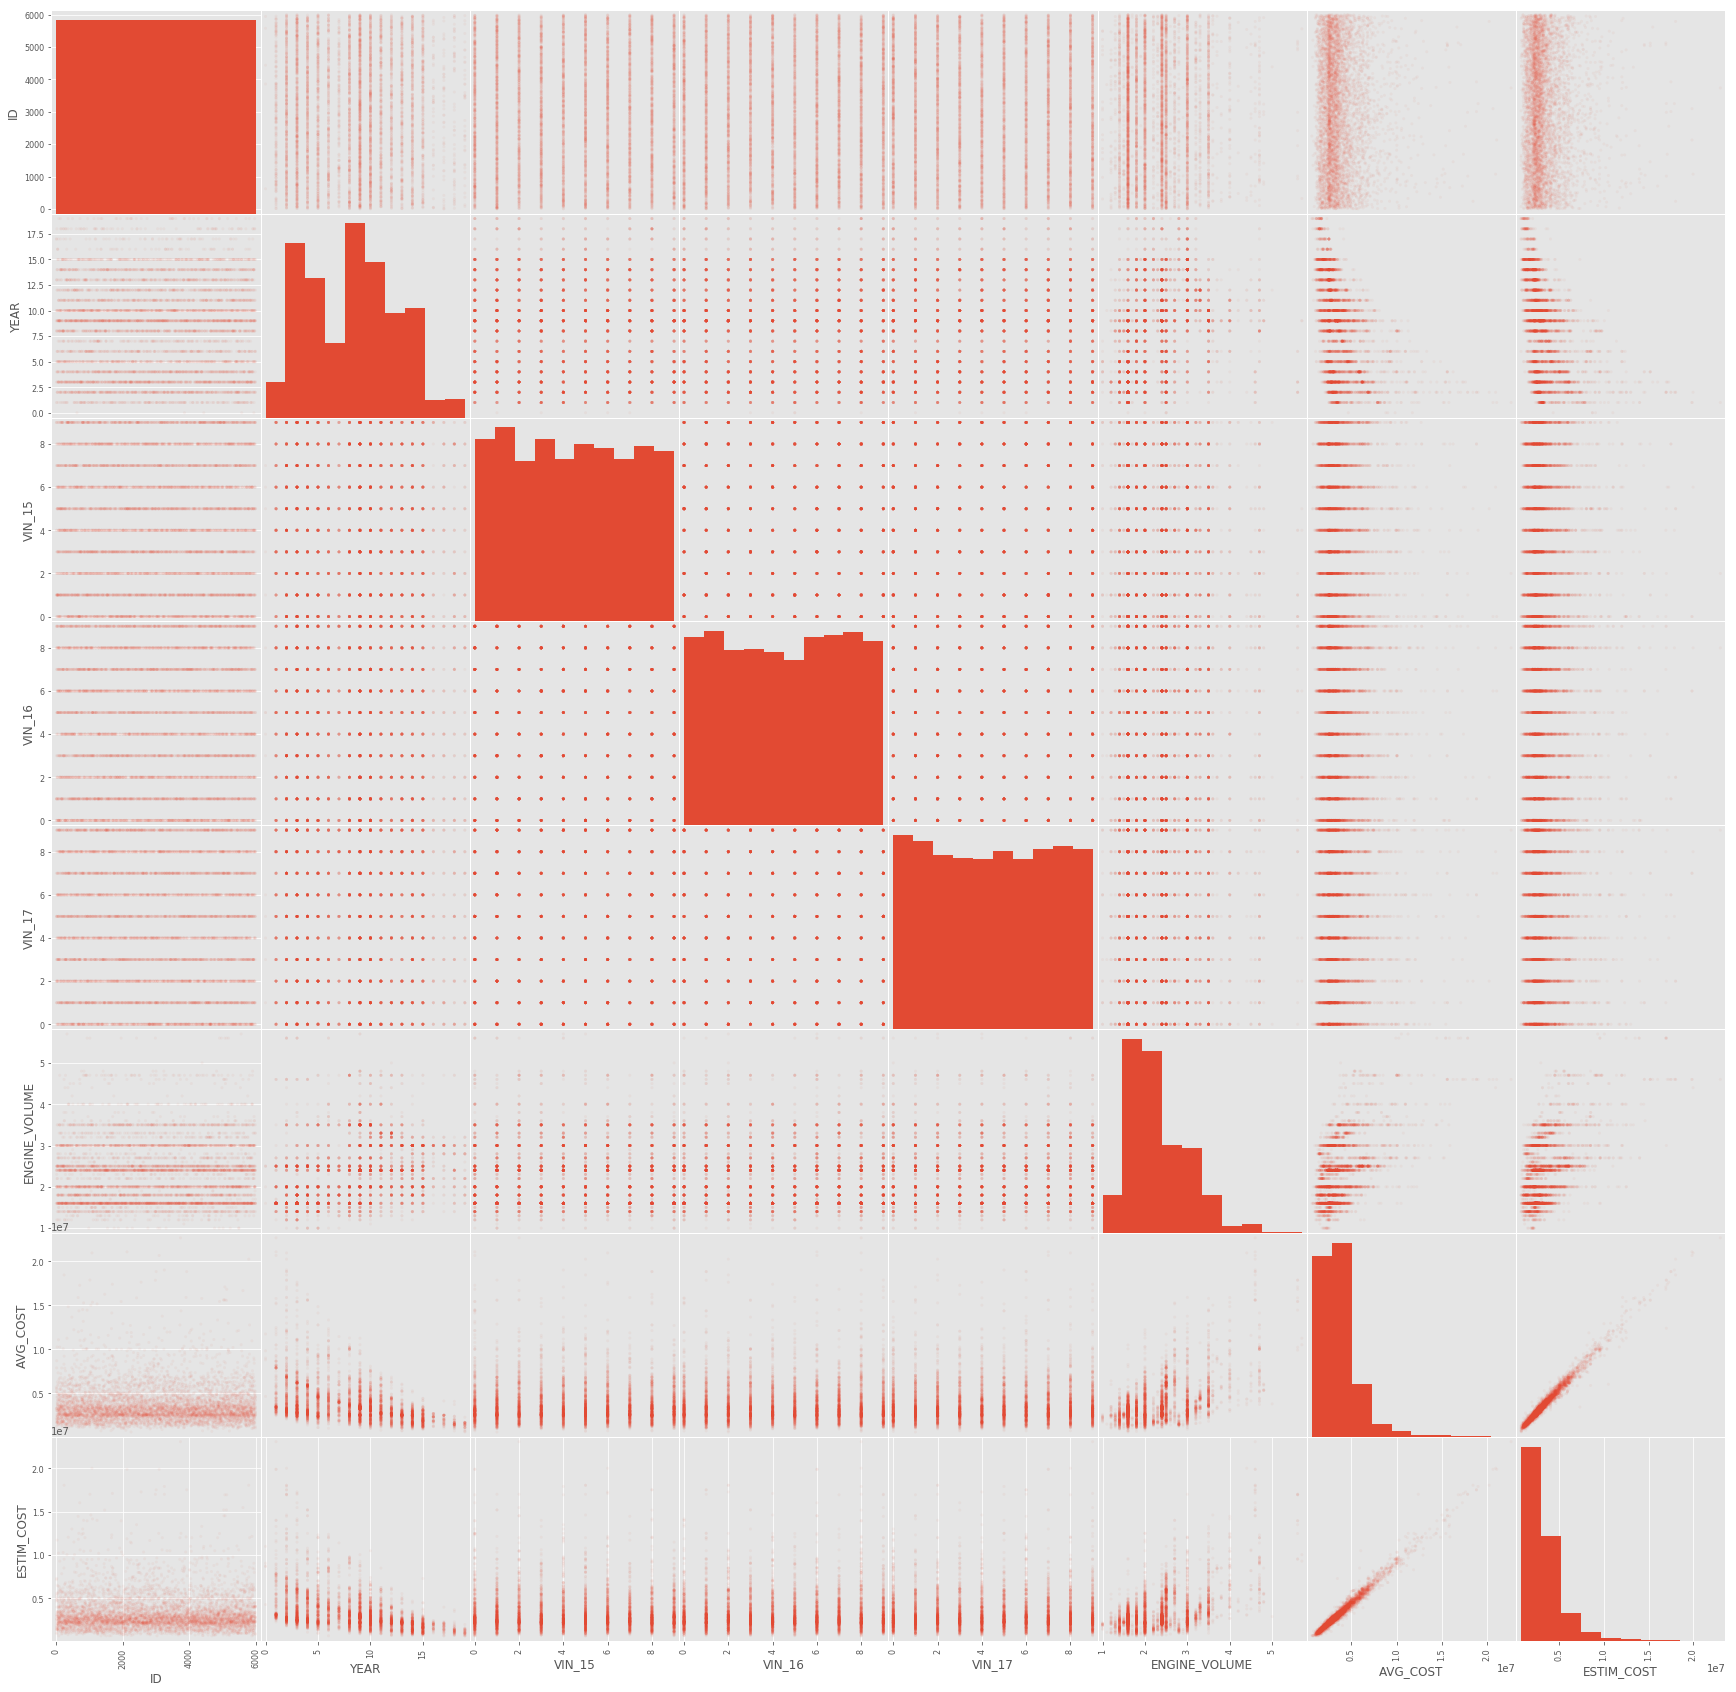

In [42]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.05, figsize=(30, 30));
plt.show()

Из построенных диаграмм видно, что признаки не сильно коррелируют с VIN кодом. Но в тоже время есть несколько неплохих признаков. Что впрочем можно также легко установить, посмотрев на корреляционную матрицу. Обращаем внимание на недиагональные значения по модулю, которые превосходят 0.4:

In [43]:
data.corr()

,ID,YEAR,VIN_15,VIN_16,VIN_17,ENGINE_VOLUME,AVG_COST,ESTIM_COST
ID,1.000000,0.016403,0.012278,0.004061,-0.017115,0.025563,-0.012134,-0.016639
YEAR,0.016403,1.000000,-0.022704,0.000678,-0.012879,0.335496,-0.431138,-0.445124
VIN_15,0.012278,-0.022704,1.000000,-0.010618,0.008581,-0.022843,-0.005622,-0.010253
VIN_16,0.004061,0.000678,-0.010618,1.000000,0.007773,-0.004240,0.009538,0.012148
VIN_17,-0.017115,-0.012879,0.008581,0.007773,1.000000,-0.018639,0.004427,0.004123
ENGINE_VOLUME,0.025563,0.335496,-0.022843,-0.004240,-0.018639,1.000000,0.506566,0.487669
AVG_COST,-0.012134,-0.431138,-0.005622,0.009538,0.004427,0.506566,1.000000,0.987254
ESTIM_COST,-0.016639,-0.445124,-0.010253,0.012148,0.004123,0.487669,0.987254,1.000000


Таким образом, считаем признаки VIN кода несущественными и удаляем их из данных:

In [44]:
data = data.drop(data.columns[[0,2,3,4,5,6,7]], axis=1)
test = test.drop(test.columns[[0,2,3,4,5,6,7]], axis=1)

Для удобства зададим столбцам имена:

In [45]:
data.columns = ['A' + str(i) for i in range(1, 10)] + ['estim']
test.columns = ['A' + str(i) for i in range(1, 10)]

Далее мы создадим отдельный вектор **y** с выходной (целевой) признак - ответом и удалим его из таблицы с данными для обучения.

In [46]:
y = data['estim']
data = data.drop(('estim'), axis=1)

Объеденим обе таблицы с данными.
Узнаем размер новой большой таблицы.
Так же мы можем посмотреть на несколько первых и несколько последних строк этой таблицы, чтобы получить представление об имеющихся данных:

In [47]:
data = pd.concat((data, test), axis=0)
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9
0,9,3.0,Бензин-Газ,Внедорожник,Полный привод,КОЖА,АКПП,Удовлетворительное,5725925.926
1,10,1.6,Бензин,Седан,Передний привод,ВЕЛЮР,МКПП,Удовлетворительное,2211538.462
2,17,2.4,Бензин,Седан,Передний привод,ВЕЛЮР,АКПП,Удовлетворительное,1260975.610
3,4,1.6,Бензин,Седан,Передний привод,ВЕЛЮР,АКПП,Отличное,3287777.778
4,17,3.0,Бензин,Внедорожник,Полный привод,КОЖА,АКПП,Удовлетворительное,2028915.663


In [48]:
data.tail()


,A1,A2,A3,A4,A5,A6,A7,A8,A9
3244,11,1.6,Бензин,Хэтчбек/Лифтбек,Передний привод,ВЕЛЮР,МКПП,Удовлетворительное,1646154.0
3245,14,1.6,Бензин,Хэтчбек/Лифтбек,Передний привод,ВЕЛЮР,АКПП,Удовлетворительное,1521795.0
3246,12,2.0,Бензин,Седан,Полный привод,ВЕЛЮР,МКПП,Хорошее,2197778.0
3247,4,1.6,Бензин,Хэтчбек/Лифтбек,Передний привод,ВЕЛЮР,АКПП,Хорошее,3002381.0
3248,10,3.5,Бензин-Газ,Седан,Передний привод,КОЖА,АКПП,Хорошее,3716667.0


In [49]:
data.shape

(9249, 9)

Выделим числовые и категориальные признаки:

In [50]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print (categorical_columns)
print (numerical_columns)

['A3', 'A4', 'A5', 'A6', 'A7', 'A8']
['A1', 'A2', 'A9']


Теперь мы можем получить некоторую общую информацию по категориальным признакам:

In [51]:
data[categorical_columns].describe()

,A3,A4,A5,A6,A7,A8
count,9249,9249,9249,9249,9249,9249
unique,5,7,3,3,2,3
top,Бензин,Седан,Передний привод,ВЕЛЮР,АКПП,Удовлетворительное
freq,7805,5412,6310,5490,7719,4770


В таблице для каждого категориального признака приведено общее число заполненных ячеек (count), количество значений, которые принимает данный признак (unique), самое популярное (часто встречающееся) значение этого признака (top) и количество объектов, в которых встречается самое частое значение данного признака (freq).

## Пропущенные значения

Узнать количество заполненных (непропущенных) элементов можно с помощью метода count. Параметр axis = 0 указывает, что мы двигаемся по размерности 0 (сверху вниз), а не размерности 1 (слева направо), т.е. нас интересует количество заполненных элементов в каждом столбце, а не строке:

In [52]:
data.count(axis=0)

A1    9249
A2    9249
A3    9249
A4    9249
A5    9249
A6    9249
A7    9249
A8    9249
A9    9249
dtype: int64

Если данные содержат пропущенные значения, то имеется две простые альтернативы:

- удалить столбцы с такими значениями (data = data.dropna(axis=1)),
- удалить строки с такими значениями (data = data.dropna(axis=0)).

После этого, к сожалению, данных может стать совсем мало, поэтому рассмотрим простые альтернативные способы.

### Категориальные признаки

In [53]:
for c in categorical_columns:
    print (data[c].unique())

['Бензин-Газ' 'Бензин' 'Дизель' 'Гибрид' 'Газ']
['Внедорожник' 'Седан' 'Кроссовер' 'Хэтчбек/Лифтбек' 'Универсал' 'Минивэн'
 'Пикап']
['Полный привод' 'Передний привод' 'Задний привод']
['КОЖА' 'ВЕЛЮР' 'КОМБИНИРОВАННЫЙ']
['АКПП' 'МКПП']
['Удовлетворительное' 'Отличное' 'Хорошее']


In [54]:
data_describe = data.describe(include=[object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

In [55]:
data.describe(include=[object])

,A3,A4,A5,A6,A7,A8
count,9249,9249,9249,9249,9249,9249
unique,5,7,3,3,2,3
top,Бензин,Седан,Передний привод,ВЕЛЮР,АКПП,Удовлетворительное
freq,7805,5412,6310,5490,7719,4770


## Векторизация 

Библиотека scikit-learn не умеет напрямую обрабатывать категориальные признаки. Поэтому прежде чем подавать данные на вход алгоритмов машинного обучения преобразуем категориальные признаки в количественные.

Категориальные признаки, принимающие два значения (т.е. бинарные признаки) и принимающие большее количество значений будем обрабатывать по-разному.

Вначале выделим бинарные и небинарные признаки:

In [56]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print (binary_columns, nonbinary_columns)

['A7'] ['A3', 'A4', 'A5', 'A6', 'A8']


### Бинарные признаки

Значения бинарных признаков просто заменим на 0 и 1. 

In [57]:
for c in binary_columns[0:]:
    top = data_describe[c]['top']
    top_items = data[c] == top
    data.loc[top_items, c] = 0
    data.loc[np.logical_not(top_items), c] = 1

Посмотрим на результат:

In [58]:
data[binary_columns].describe()

,A7
count,9249
unique,2
top,0
freq,7719


### Небинарные признаки

 небинарными признакам применим метод векторизации, который заключается в следующем.

Признак j, принимающий s значений, заменим на s признаков, принимащих значения 0 или 1, в зависимости от того, чему равно значение исходного признака j.

Например, признак A4 принимает 3 различных значения 'u', 'y', 'l'
    
Заменим признак A4 тремя признаками: A4_u, A4_y, A4_l.

- Если признак A4 принимает значение u, то признак A4_u равен 1, A4_y равен 0, A4_l равен 0.
- Если признак A4 принимает значение y, то признак A4_y равен 0, A4_y равен 1, A4_l равен 0.
- Если признак A4 принимает значение l, то признак A4_l равен 0, A4_y равен 0, A4_l равен 1.

Такую векторизацию осуществляет в pandas метод get_dummies:

In [59]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print (data_nonbinary.columns)

Index(['A3_Бензин', 'A3_Бензин-Газ', 'A3_Газ', 'A3_Гибрид', 'A3_Дизель',
       'A4_Внедорожник', 'A4_Кроссовер', 'A4_Минивэн', 'A4_Пикап', 'A4_Седан',
       'A4_Универсал', 'A4_Хэтчбек/Лифтбек', 'A5_Задний привод',
       'A5_Передний привод', 'A5_Полный привод', 'A6_ВЕЛЮР', 'A6_КОЖА',
       'A6_КОМБИНИРОВАННЫЙ', 'A8_Отличное', 'A8_Удовлетворительное',
       'A8_Хорошее'],
      dtype='object')


## Соединяем все в одну таблицу

In [60]:
data_numerical = data[numerical_columns]
# data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
data_numerical.describe()

,A1,A2,A9
count,9249.000000,9249.000000,9.249000e+03
mean,8.219267,2.295254,3.683657e+06
std,4.453860,0.711892,2.119796e+06
min,0.000000,1.000000,6.061730e+05
25%,4.000000,1.600000,2.482022e+06
50%,9.000000,2.300000,3.157692e+06
75%,12.000000,2.700000,4.297619e+06
max,19.000000,5.700000,2.266484e+07


In [61]:
data = pd.concat((data_numerical, data[binary_columns], data_nonbinary), axis=1)
data = pd.DataFrame(data, dtype=float)
print (data.shape)
print (data.columns)

(9249, 25)
Index(['A1', 'A2', 'A9', 'A7', 'A3_Бензин', 'A3_Бензин-Газ', 'A3_Газ',
       'A3_Гибрид', 'A3_Дизель', 'A4_Внедорожник', 'A4_Кроссовер',
       'A4_Минивэн', 'A4_Пикап', 'A4_Седан', 'A4_Универсал',
       'A4_Хэтчбек/Лифтбек', 'A5_Задний привод', 'A5_Передний привод',
       'A5_Полный привод', 'A6_ВЕЛЮР', 'A6_КОЖА', 'A6_КОМБИНИРОВАННЫЙ',
       'A8_Отличное', 'A8_Удовлетворительное', 'A8_Хорошее'],
      dtype='object')


Для удобства отдельно рассмотрим столбцы, соответствующие входным признакам (это будет матрица X)

In [62]:
X = data
feature_names = X.columns
print (feature_names)

Index(['A1', 'A2', 'A9', 'A7', 'A3_Бензин', 'A3_Бензин-Газ', 'A3_Газ',
       'A3_Гибрид', 'A3_Дизель', 'A4_Внедорожник', 'A4_Кроссовер',
       'A4_Минивэн', 'A4_Пикап', 'A4_Седан', 'A4_Универсал',
       'A4_Хэтчбек/Лифтбек', 'A5_Задний привод', 'A5_Передний привод',
       'A5_Полный привод', 'A6_ВЕЛЮР', 'A6_КОЖА', 'A6_КОМБИНИРОВАННЫЙ',
       'A8_Отличное', 'A8_Удовлетворительное', 'A8_Хорошее'],
      dtype='object')


In [63]:
print (X.shape)
print (X.columns)
print (y.shape)
N, d = X.shape

(9249, 25)
Index(['A1', 'A2', 'A9', 'A7', 'A3_Бензин', 'A3_Бензин-Газ', 'A3_Газ',
       'A3_Гибрид', 'A3_Дизель', 'A4_Внедорожник', 'A4_Кроссовер',
       'A4_Минивэн', 'A4_Пикап', 'A4_Седан', 'A4_Универсал',
       'A4_Хэтчбек/Лифтбек', 'A5_Задний привод', 'A5_Передний привод',
       'A5_Полный привод', 'A6_ВЕЛЮР', 'A6_КОЖА', 'A6_КОМБИНИРОВАННЫЙ',
       'A8_Отличное', 'A8_Удовлетворительное', 'A8_Хорошее'],
      dtype='object')
(6000,)


## Обучающая и тестовая выборки

Все готово, чтобы запустить алгоритмы машинного обучения.
Разобъем нашу большу таблицу на две. Тренировочную и тестовую:

In [64]:
X_train = data[:6000]
X_test = data[6000:]

Обучаться, или, как говорят, строить модель, мы будем на обучающей выборке, а проверять качество построенной модели – на тестовой.

В рассматриваемой задаче мы сами разобьем имеющиеся у нас данные на обучающую и тестовую выборки.

Разбиение на тестовую и обучающую выборку должно быть случайным. Обычно используют разбиения в пропорции 50%:50%, 60%:40%, 75%:25% и т.д.

Мы воспользуемся функцией train_test_split из модуля sklearn.cross_validation. и разобьем данные на обучающую/тестовую выборки в отношении 70%:30%

In [65]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y, test_size = 0.3, random_state = 11)

N_train, _ = X_train1.shape 
N_test,  _ = X_test1.shape 
print (N_train, N_test)

4200 1800


train, y_train – это обучающая выборка, test, y_test – тестовая.

## Алгоритм машинного обучения - градиентный бустинг деревьев решений

Градиентный бустинг деревьев решений метод, строящий ансамбль деревьев решений. На каждой итерации строится новый классификатор, аппроксимирующий значение градиента функции потерь.
Основные методы классов, реализующих алгоритмы машинного обучения
Все алгоритмы выполнены в виде классов, обладающих по крайней мере следующими методами:
- fit(X, y) - обучение (тренировка) модели на обучающей выборке X, y
- predict(X) - предсказание на данных X

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
model1 = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, loss='ls')

In [68]:
model1.fit(X_train1, y_train1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Оценим качество построенной модели с помощью методов кросс валидации:

In [71]:
print("Score:" + str(model1.score(X_test1,y_test1)))

Score:0.977443007999


После того, как модель обучена, мы можем предсказывать значение целевого признака по входным признакам для новых объектов. Делается это с помощью метода predict.

In [70]:
a1 = model1.predict(X_test1)

### Построим модель на полных обучающих данных и получим предсказание на тестовой выборке

In [72]:
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, loss='ls')

In [73]:
model.fit(X_train,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [74]:
a = model.predict(X_test)

Выгрузим данные в CSV файл

In [75]:
pd.DataFrame(a).to_csv('prediction.csv')

In [76]:
print(a)

[ 1479053.30963637  3651458.23746311  4517666.75763538 ...,
  1923284.62027026  2676390.69742743  3280634.95714311]
